# Model selection

Up to now, we have seen many ways to use models from the `sklearn` library to help solve your machine learning problems. Once you know how to use these models, an important question is that of model selection.

In this section of the tutorial, we will deal with two important questions related to model selection:
1. How to select a model that achieves a reasonable trade-off between underfitting (aka bias) and overfitting (aka variance);
2. How to perform parameter tuning with `sklearn`.

## Underfitting _vs_ overfitting

Let us consider the problem of explaining variable `y` using covariate `X` in the following case:

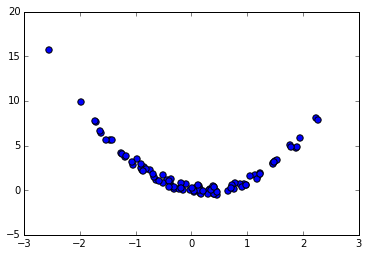

In [1]:
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X = np.random.randn(100, 1)
y = 2 * X ** 2 - X + .3 * np.random.randn(100, 1)
plt.scatter(X, y, s=40)

Of course, if we want to fit a linear regression model to this data, we do not get great results:

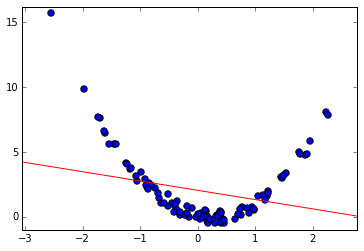

In [2]:
def plot_regression(regressor, data, y, tf=None):
    plt.scatter(data[:, 0], y, s=40)
    X = np.linspace(data[:,0].min() - .5, data[:,0].max() + .5, 100).reshape((100, 1))
    if tf is None:
        y_pred = regressor.predict(X)
    else:
        y_pred = regressor.predict(tf.fit_transform(X))
    plt.plot(X, y_pred, color="r")
    plt.xlim(data[:,0].min() - .5, data[:,0].max() + .5)
    plt.ylim(y.min() - .5, y.max() + .5)

regressor = LinearRegression()
regressor.fit(X, y)
plot_regression(regressor, X, y)

We are in a typical case of underfitting: our model is not complex enough to explain our data.

Let us see what happens if we now feed our linear regressor with polynomial features:

(100, 3)


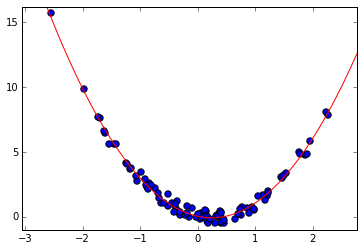

In [3]:
tf = PolynomialFeatures(degree=2)
X_deg2 = tf.fit_transform(X)
print(X_deg2.shape) # Col. 0: constant, Col. 1: X, Col. 2: X^2

regressor_deg2 = LinearRegression()
regressor_deg2.fit(X_deg2, y)
plot_regression(regressor_deg2, X, y, tf=tf)

Here, it seems the model fits pretty well our data. And if we had used higher degree polynomial representation:

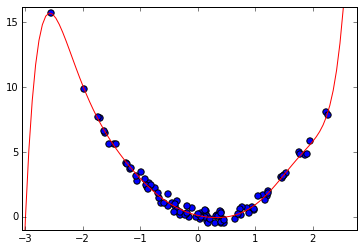

In [4]:
tf = PolynomialFeatures(degree=10)
X_deg10 = tf.fit_transform(X)

regressor_deg10 = LinearRegression()
regressor_deg10.fit(X_deg10, y)
plot_regression(regressor_deg10, X, y, tf=tf)

Here, it is quite clear that we are overfitting the data. 

To see this, we can have a look at the $R^2$:

In [5]:
print(regressor_deg2.score(X_deg2, y))
print(regressor_deg10.score(X_deg10, y))

0.98683319423
0.988025974709


In this case, the $R^2$ is not able to show that degree 10 polynomial regression is overfitting.

To better assess whether a fitted model tends to underfit or overfit the data, it is necessary to split our data into a train set and a validation set.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

for degree in range(1, 11):
    tf = PolynomialFeatures(degree=degree)
    X_train_poly = tf.fit_transform(X_train)
    X_test_poly = tf.fit_transform(X_test)

    regressor = LinearRegression()
    regressor.fit(X_train_poly, y_train)
    print(degree, regressor.score(X_test_poly, y_test))

1 -0.150174605536
2 0.989327576712
3 0.98875729718
4 0.989462491585
5 0.980318724099
6 0.913716903047
7 0.799959199313
8 0.255051844284
9 0.444334215095
10 -6.52795449077


To get more reliable results, it is recommended to use $k$-fold cross validation:

In [7]:
from sklearn.model_selection import cross_val_score, KFold

for degree in range(1, 11):
    tf = PolynomialFeatures(degree=degree)
    X_poly = tf.fit_transform(X)
    scores = cross_val_score(LinearRegression(), X_poly, y, cv=KFold(n_splits=3))
    print(degree, scores.mean())

1 -0.0473348727
2 0.97998648803
3 0.979919207038
4 0.980795367286
5 0.966331415499
6 0.951232294194
7 0.640549302997
8 -2.36809778361
9 -0.837808309871
10 -46.5247428935


This indicates that we should pick a degree between 2 and 6.

## Parameter tuning

We now turn our focus on setting adequate values for hyperparameters in diverse machine learning problems. In the following, we will consider the case of Support Vector Machines for Classification, but what we will see can be straight-forwardly extended to other `sklearn` models.



In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles

X, y = make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.3, random_state=0)
dict_params = {"C": [.01, .1, 1., 10.]}
clf = GridSearchCV(estimator=SVC(kernel="linear"), param_grid=dict_params, cv=KFold(n_splits=3))
clf.fit(X, y)

print(clf.best_estimator_)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


The value $C=0.01$ seems the best when using cross-validation on the training set. A similar scheme can also be used to pick the adequate kernel for SVM:

In [9]:
X, y = make_circles(n_samples=100, random_state=0, noise=.1, factor=.5)
dict_params = {"C": [.01, .1, 1., 10.], "kernel": ["linear", "rbf"]}
clf = GridSearchCV(estimator=SVC(kernel="linear"), param_grid=dict_params, cv=KFold(n_splits=3))
clf.fit(X, y)

print(clf.best_estimator_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
